# NER using BiLSTM with Elmo Embeddings

We will use a residual LSTM network together with ELMo embeddings from TF Hub.

https://www.depends-on-the-definition.com/named-entity-recognition-with-residual-lstm-and-elmo/

https://www.depends-on-the-definition.com/interpretable-named-entity-recognition/




In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np 
import texthero as hero
import tensorflow_hub as hub


import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(f'Using Device: {tf.config.list_physical_devices("GPU")}')

Using Device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
data = pd.read_csv('../Data/ner_dataset.csv',encoding='latin1')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
data.drop(columns=['POS'],inplace=True)
data = data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
5,Sentence: 1,through,O
6,Sentence: 1,London,B-geo
7,Sentence: 1,to,O
8,Sentence: 1,protest,O
9,Sentence: 1,the,O


In [5]:
words = list(set(data.Word))
words.append('ENDPAD')
n_words = len(words)

print(f'Total number of unique words: {n_words}')

Total number of unique words: 35179


In [6]:
words[:10]

['Buehring',
 'sure',
 'farfetched',
 '3,348',
 '1795',
 'divorced',
 'wisely',
 'grenades',
 'suicide',
 'firewood']

In [7]:
tags = list(set(data.Tag))
n_tags = len(tags)

print(f'Number of unique tags: {n_tags}')

Number of unique tags: 17


In [8]:
class sentence_getter():
    def __init__(self,data):
        agg_function = lambda s:[(w,t) for w,t in zip(s['Word'].values.tolist(),
                                                      s['Tag'].values.tolist())]
        self.grouped_data = data.groupby('Sentence #').apply(agg_function)
        self.sentences = [s for s in self.grouped_data]

In [9]:
getter = sentence_getter(data)
sentences = getter.sentences
sentences[2]

[('Helicopter', 'O'),
 ('gunships', 'O'),
 ('Saturday', 'B-tim'),
 ('pounded', 'O'),
 ('militant', 'O'),
 ('hideouts', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('Orakzai', 'B-geo'),
 ('tribal', 'O'),
 ('region', 'O'),
 (',', 'O'),
 ('where', 'O'),
 ('many', 'O'),
 ('Taliban', 'B-org'),
 ('militants', 'O'),
 ('are', 'O'),
 ('believed', 'O'),
 ('to', 'O'),
 ('have', 'O'),
 ('fled', 'O'),
 ('to', 'O'),
 ('avoid', 'O'),
 ('an', 'O'),
 ('earlier', 'O'),
 ('military', 'O'),
 ('offensive', 'O'),
 ('in', 'O'),
 ('nearby', 'O'),
 ('South', 'B-geo'),
 ('Waziristan', 'I-geo'),
 ('.', 'O')]

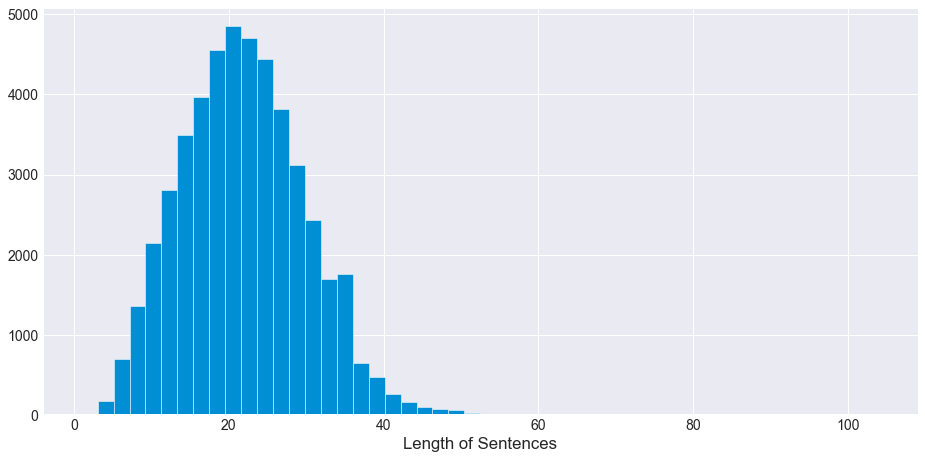

In [10]:
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(14,7))
plt.hist([len(s) for s in sentences],bins = 50)
plt.xlabel("Length of Sentences")
plt.show()

In [11]:
max_len = 50
tag2idx = {t: i for i, t in enumerate(tags)}

In [12]:
tag2idx

{'B-per': 0,
 'I-tim': 1,
 'B-org': 2,
 'B-tim': 3,
 'I-geo': 4,
 'I-eve': 5,
 'I-art': 6,
 'I-org': 7,
 'B-geo': 8,
 'I-per': 9,
 'B-art': 10,
 'B-eve': 11,
 'B-nat': 12,
 'B-gpe': 13,
 'O': 14,
 'I-nat': 15,
 'I-gpe': 16}

To apply the EMLo embedding from tensorflow hub, we have to use strings as input. So we take the tokenized sentences and pad them to the desired length.

In [13]:
X = [[w[0] for w in  s] for s in sentences]

In [14]:
new_X = []
for sent_sequence in X:
    new_sent_sequence = []
    for i in range(max_len):
        try:
            # append word on the sentence
            new_sent_sequence.append(sent_sequence[i])
        except:
            # If sequence is less than 50 tokens, add padding manually
            new_sent_sequence.append('__PAD__')
    new_X.append(new_sent_sequence)

In [15]:
new_X[2]

['Helicopter',
 'gunships',
 'Saturday',
 'pounded',
 'militant',
 'hideouts',
 'in',
 'the',
 'Orakzai',
 'tribal',
 'region',
 ',',
 'where',
 'many',
 'Taliban',
 'militants',
 'are',
 'believed',
 'to',
 'have',
 'fled',
 'to',
 'avoid',
 'an',
 'earlier',
 'military',
 'offensive',
 'in',
 'nearby',
 'South',
 'Waziristan',
 '.',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__',
 '__PAD__']

we need to do the same for our tag sequence, but map the string to an integer.

In [16]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = tf.keras.preprocessing.sequence.pad_sequences(maxlen=max_len,sequences=y,padding='post',value=tag2idx['O'])

In [17]:
y[2]

array([14, 14,  3, 14, 14, 14, 14, 14,  8, 14, 14, 14, 14, 14,  2, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,  8,  4, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14])

In [18]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(new_X,y,test_size = 0.1,random_state = 42)

In [19]:
batch_size = 16

In [20]:
import tensorflow_hub as hub 
import tensorflow.compat.v1 as tf1
tf1.disable_eager_execution()
tf1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [21]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

from cachetools import TTLCache,cached
cache = TTLCache(maxsize=100, ttl=21600)

# @cached(cache)
# def ELMoEmbedding(x):
#     return elmo(tf.reshape(tf.cast(x,tf.string),[-1]),signature='default',as_dict=True)['elmo']
@cached(cache)
def ElmoEmbedding(x):
    return elmo(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(batch_size*[max_len])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [22]:
## Model Architecture

input_text = tf.keras.layers.Input(shape=(max_len,), dtype='string',name='input_text')
embedding = tf.keras.layers.Lambda(ElmoEmbedding,output_shape = (None,1024), name = 'elmo_embedding')(input_text)

x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024,return_sequences=True,recurrent_dropout=0.2,dropout=0.2))(embedding)

x_rnn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024,return_sequences=True,recurrent_dropout=0.2,dropout=0.2))(x)

#   residual connection
# x = tf.keras.layers.Concatenate(axis=1)([x,x_rnn])
x = tf.keras.layers.Add()([x,x_rnn])

out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_tags,activation='softmax'))(x)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [23]:
model =tf.keras.models.Model(input_text,out)

In [24]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text (InputLayer)         [(None, 50)]         0                                            
__________________________________________________________________________________________________
elmo_embedding (Lambda)         (16, None, 1024)     0           input_text[0][0]                 
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (16, None, 2048)     16785408    elmo_embedding[0][0]             
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (16, None, 2048)     25174016    bidirectional[0][0]              
_______________________________________________________________________________________

In [25]:
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)

# history = model.fit(np.array(X_train),y,
#                     validation_split=0.2,
#                     batch_size = batch_size,
#                     epochs = 1,
#                     verbose=False,
#                     callbacks= [early_stopping] )

In [26]:
X_train, X_val = X_train[:1213*batch_size], X_train[-135*batch_size:]
y_train, y_val = y_train[:1213*batch_size], y_train[-135*batch_size:]

y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1], 1)

In [27]:

with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    sess.run(tf.compat.v1.tables_initializer())

    history = model.fit(np.array(X_train),y_train,epochs=1,validation_data=(np.array(X_val), y_val),batch_size = batch_size)
    model.save_weights('../Models/NER_ELMo_biLSTM.h5')

Train on 19408 samples, validate on 2160 samples
 1248/19408 [>.............................] - ETA: 37:00 - loss: 0.2233 - acc: 0.9477